In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt
import pyproj

# import utm
import geopandas as gpd

import pathlib
import os

import warnings
warnings.filterwarnings("ignore")

# Load gravity data table

In [2]:
data_dir = pathlib.Path("..") / "data"
image_dir = pathlib.Path("..") / "report" / "figures"
shape_dir = pathlib.Path("..") / "data" / "shapefile"

mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

Read shapefile

In [3]:
pluton = os.path.join(shape_dir/"corrego_seco.shp")

Read regional data

In [4]:
data = pd.read_csv(data_dir/'regional_data.csv', delimiter=';')
# data = data.iloc[::5]  # Seleciona a cada 4 linhas

In [5]:
data.head(5)

Station  Longitude   Latitude  Elevation        Gravity
0        2 -50.172917 -16.597917      594.0  978288.210050
1        3 -50.168750 -16.597917      595.0  978287.413200
2        4 -50.164583 -16.597917      603.0  978284.467233
3        5 -50.160417 -16.597917      616.0  978279.995975
4        6 -50.156250 -16.597917      626.0  978276.475002

In [6]:
region = (-50.172916666667, -49.806250000000, -16.597916666667, -16.222916666667)
region_pad = vd.pad_region(region, pad=0.00)
print(region_pad)

(-50.172916666667, -49.80625, -16.597916666667, -16.222916666667)


In [65]:
# topography_copy = pygmt.datasets.load_earth_relief(resolution="15s", region=region_pad)
topography = pygmt.datasets.load_earth_relief(resolution="15s", region=region_pad)
topography = topography.rename({'lon': 'longitude', 'lat': 'latitude'})
topography

<xarray.DataArray 'z' (latitude: 91, longitude: 89)> Size: 65kB
array([[594., 595., 603., ..., 691., 739., 736.],
       [609., 606., 612., ..., 678., 705., 713.],
       [618., 613., 629., ..., 684., 705., 716.],
       ...,
       [777., 770., 776., ..., 840., 870., 868.],
       [781., 781., 789., ..., 847., 869., 875.],
       [808., 792., 767., ..., 843., 869., 880.]])
Coordinates:
  * latitude   (latitude) float64 728B -16.6 -16.59 -16.59 ... -16.23 -16.22
  * longitude  (longitude) float64 712B -50.17 -50.17 -50.16 ... -49.81 -49.81
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_relief_15s_p/ -R-50.175/-49.804166...
    description:       IGPP Earth relief
    long_name:         z
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [66]:
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
# km_per_degree = 111  
# wavelength_deg = 3 / km_per_degree  
# topography = hm.filters.gaussian_lowpass_kernel(topography, wavelength_deg)*1000
topography

<xarray.DataArray 'z' (latitude: 90, longitude: 89)> Size: 64kB
array([[594., 595., 603., ..., 691., 739., 736.],
       [609., 606., 612., ..., 678., 705., 713.],
       [618., 613., 629., ..., 684., 705., 716.],
       ...,
       [769., 779., 802., ..., 830., 860., 831.],
       [777., 770., 776., ..., 840., 870., 868.],
       [781., 781., 789., ..., 847., 869., 875.]])
Coordinates:
  * latitude   (latitude) float64 720B -16.6 -16.59 -16.59 ... -16.23 -16.23
  * longitude  (longitude) float64 712B -50.17 -50.17 -50.16 ... -49.81 -49.81
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_relief_15s_p/ -R-50.175/-49.804166...
    description:       IGPP Earth relief
    long_name:         z
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [67]:
topography_table = vd.grid_to_table(topography)
# topography_table.to_csv('topography_grid.grd', index=False, sep=' ')

In [68]:
# geoid = pygmt.datasets.load_earth_geoid(resolution="01m", region=region_pad, registration="gridline")
geoid = pygmt.datasets.load_earth_geoid(resolution="01m", 
                                        region=np.array(vd.get_region(
                                            (topography.coords['longitude'], 
                                             topography.coords['latitude'])
                                        )),
                                        registration="gridline")

geoid = geoid.rename({'lon': 'longitude', 'lat': 'latitude'})

geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
geoid_1 = vd.grid_to_table(topography)

interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.z)
geoid_1 = geoid_1.assign(elevation=interpolator.predict((geoid_1.longitude, geoid_1.latitude)))

geoid_values = np.reshape(geoid_1.elevation, topography.shape)
geoid = xr.DataArray(geoid_values, coords=[topography.latitude, topography.longitude], dims=['latitude', 'longitude'])
geoid

<xarray.DataArray (latitude: 90, longitude: 89)> Size: 64kB
array([[-6.85999966, -6.85999966, -6.85999966, ..., -8.43999958,
        -8.43999958, -8.43999958],
       [-6.85999966, -6.85999966, -6.85999966, ..., -8.43999958,
        -8.43999958, -8.43999958],
       [-6.85999966, -6.85999966, -6.85999966, ..., -8.43999958,
        -8.43999958, -8.43999958],
       ...,
       [-6.83999968, -6.83999968, -6.83999968, ..., -8.0199995 ,
        -8.0199995 , -8.0199995 ],
       [-6.83999968, -6.83999968, -6.83999968, ..., -8.0199995 ,
        -8.0199995 , -8.0199995 ],
       [-6.83999968, -6.83999968, -6.83999968, ..., -8.0199995 ,
        -8.0199995 , -8.0199995 ]])
Coordinates:
  * latitude   (latitude) float64 720B -16.6 -16.59 -16.59 ... -16.23 -16.23
  * longitude  (longitude) float64 712B -50.17 -50.17 -50.16 ... -49.81 -49.81

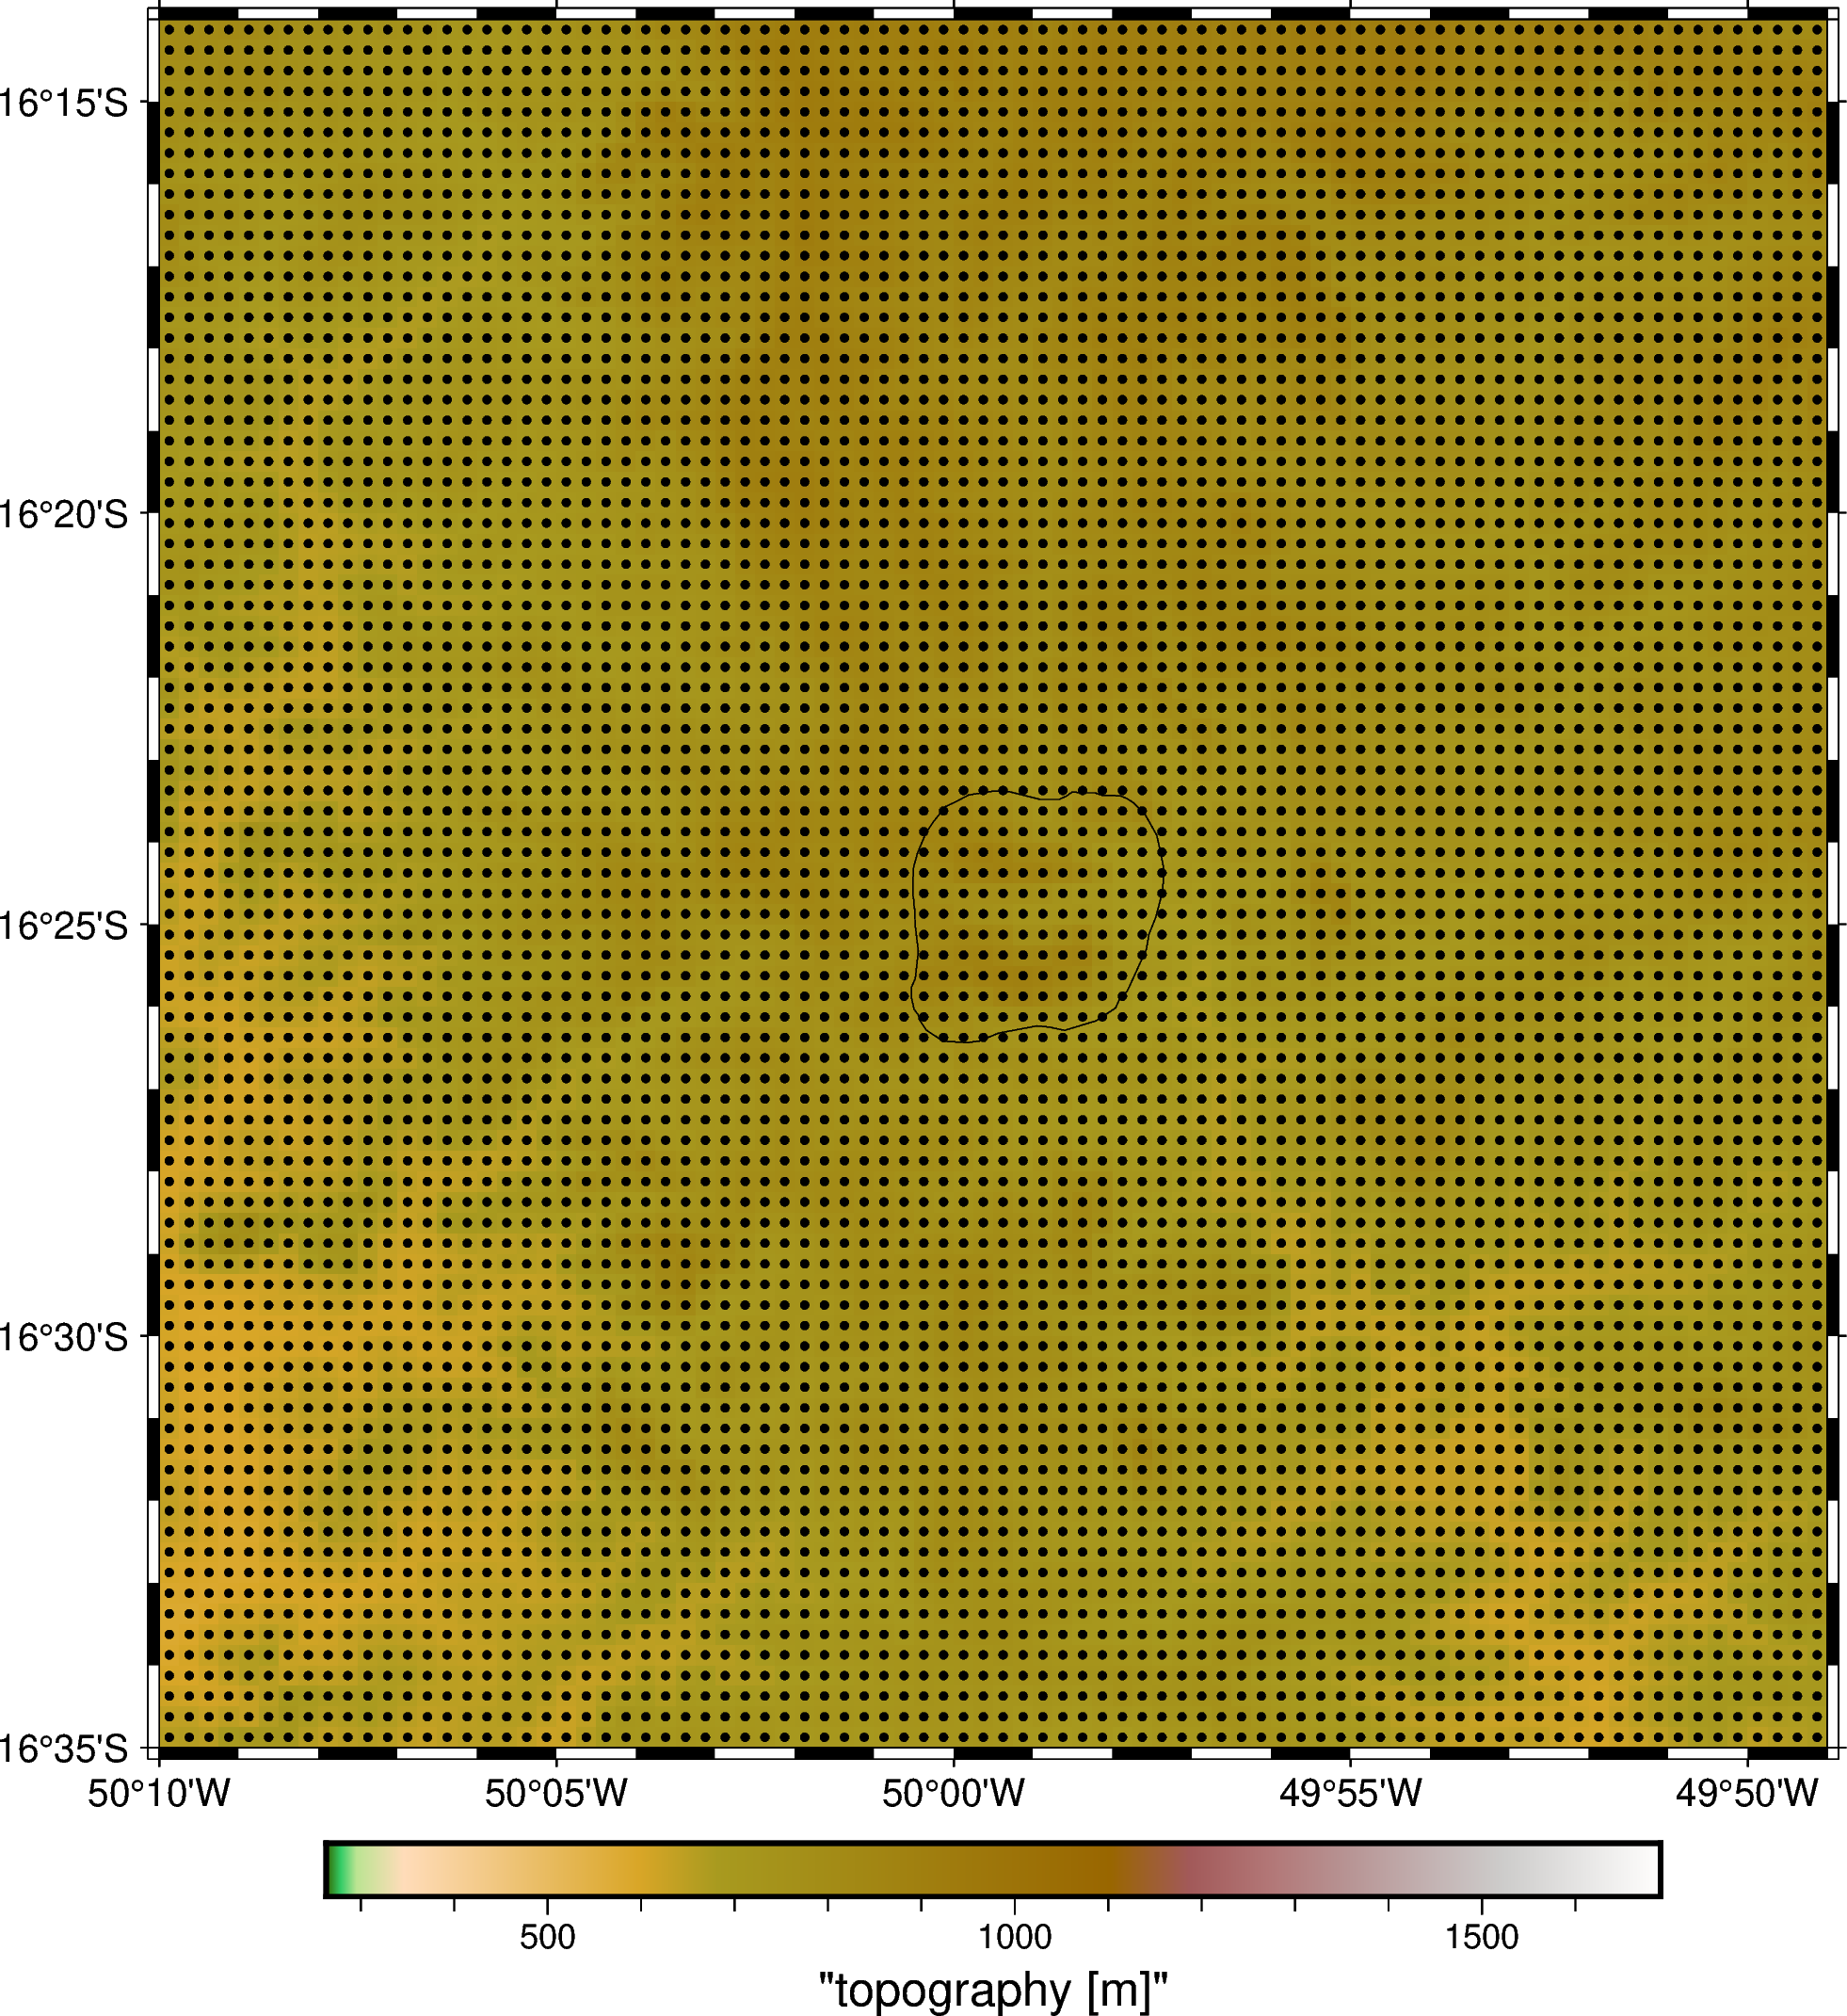

In [69]:
fig = pygmt.Figure()
fig.grdimage(topography, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
fig.show(width=600)

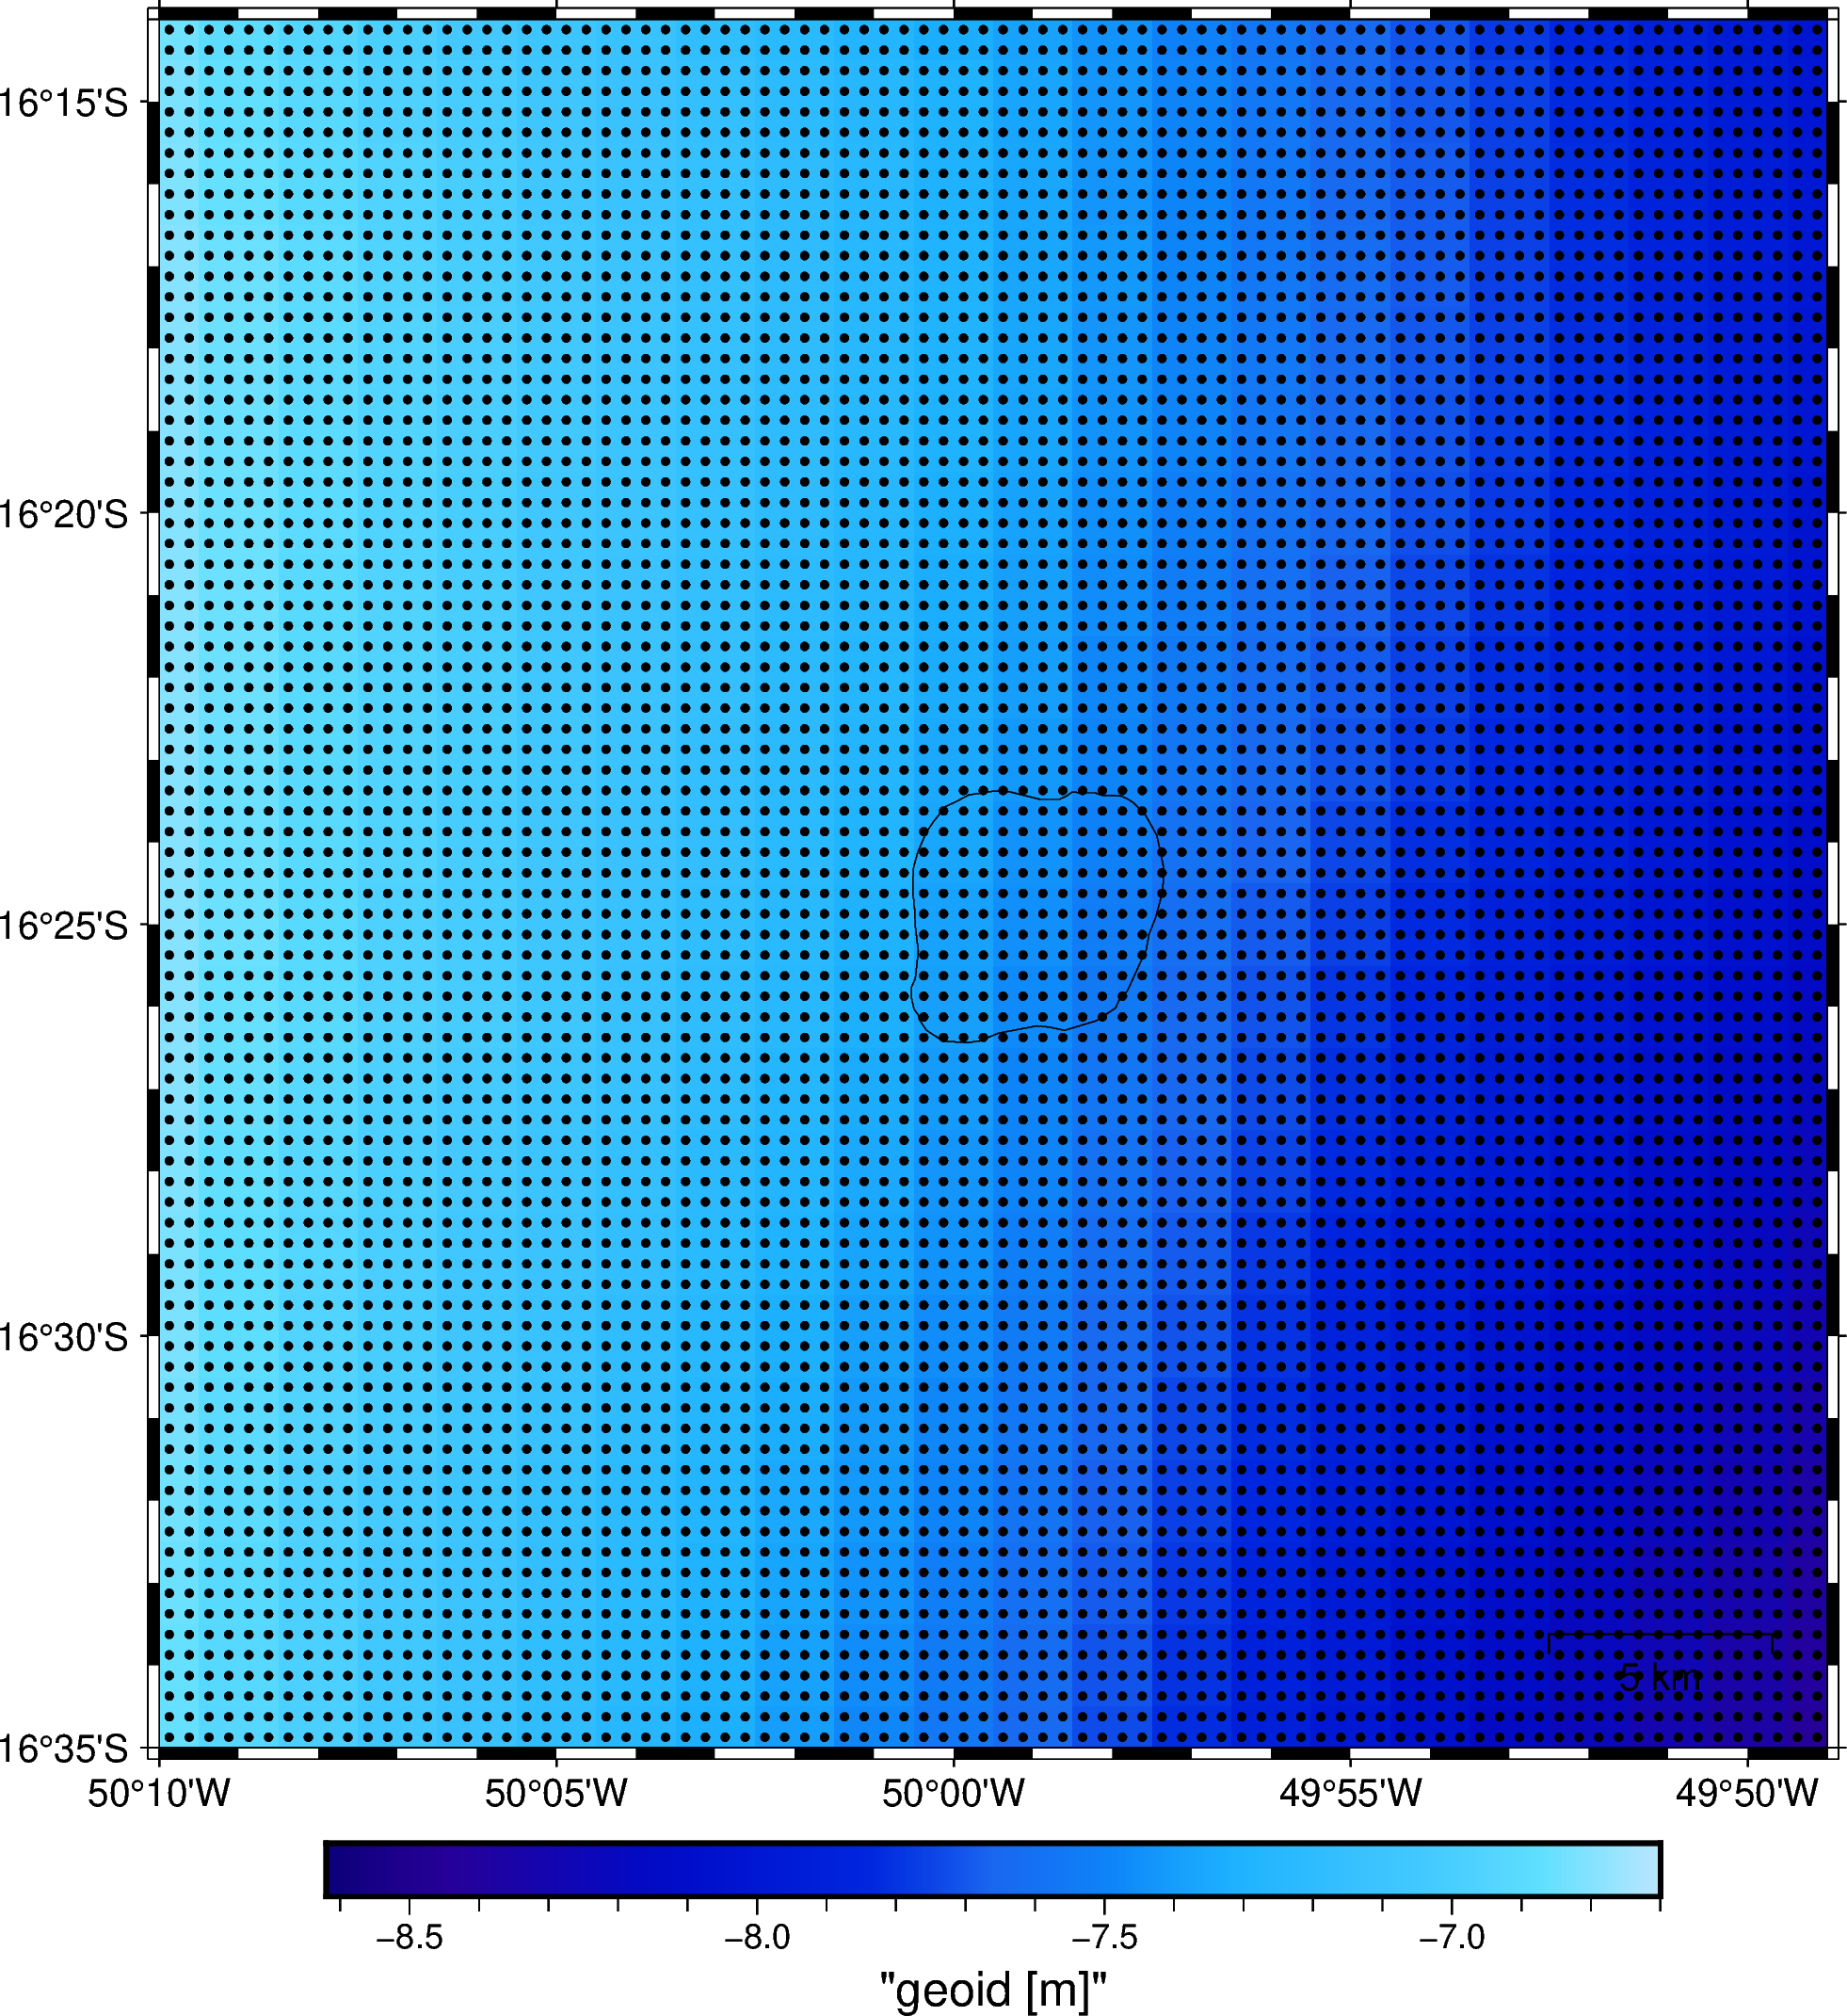

In [70]:
fig = pygmt.Figure()
fig.grdimage(geoid, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geoid [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
fig.basemap(map_scale="n0.9/0.06+w5k+u")
fig.show(width=600)

## Converte altitudes ortométricas para geométricas

In [71]:
topography_geometric = topography + geoid
topography_geometric

<xarray.DataArray (latitude: 90, longitude: 89)> Size: 64kB
array([[587.14000034, 588.14000034, 596.14000034, ..., 682.56000042,
        730.56000042, 727.56000042],
       [602.14000034, 599.14000034, 605.14000034, ..., 669.56000042,
        696.56000042, 704.56000042],
       [611.14000034, 606.14000034, 622.14000034, ..., 675.56000042,
        696.56000042, 707.56000042],
       ...,
       [762.16000032, 772.16000032, 795.16000032, ..., 821.9800005 ,
        851.9800005 , 822.9800005 ],
       [770.16000032, 763.16000032, 769.16000032, ..., 831.9800005 ,
        861.9800005 , 859.9800005 ],
       [774.16000032, 774.16000032, 782.16000032, ..., 838.9800005 ,
        860.9800005 , 866.9800005 ]])
Coordinates:
  * latitude   (latitude) float64 720B -16.6 -16.59 -16.59 ... -16.23 -16.23
  * longitude  (longitude) float64 712B -50.17 -50.17 -50.16 ... -49.81 -49.81

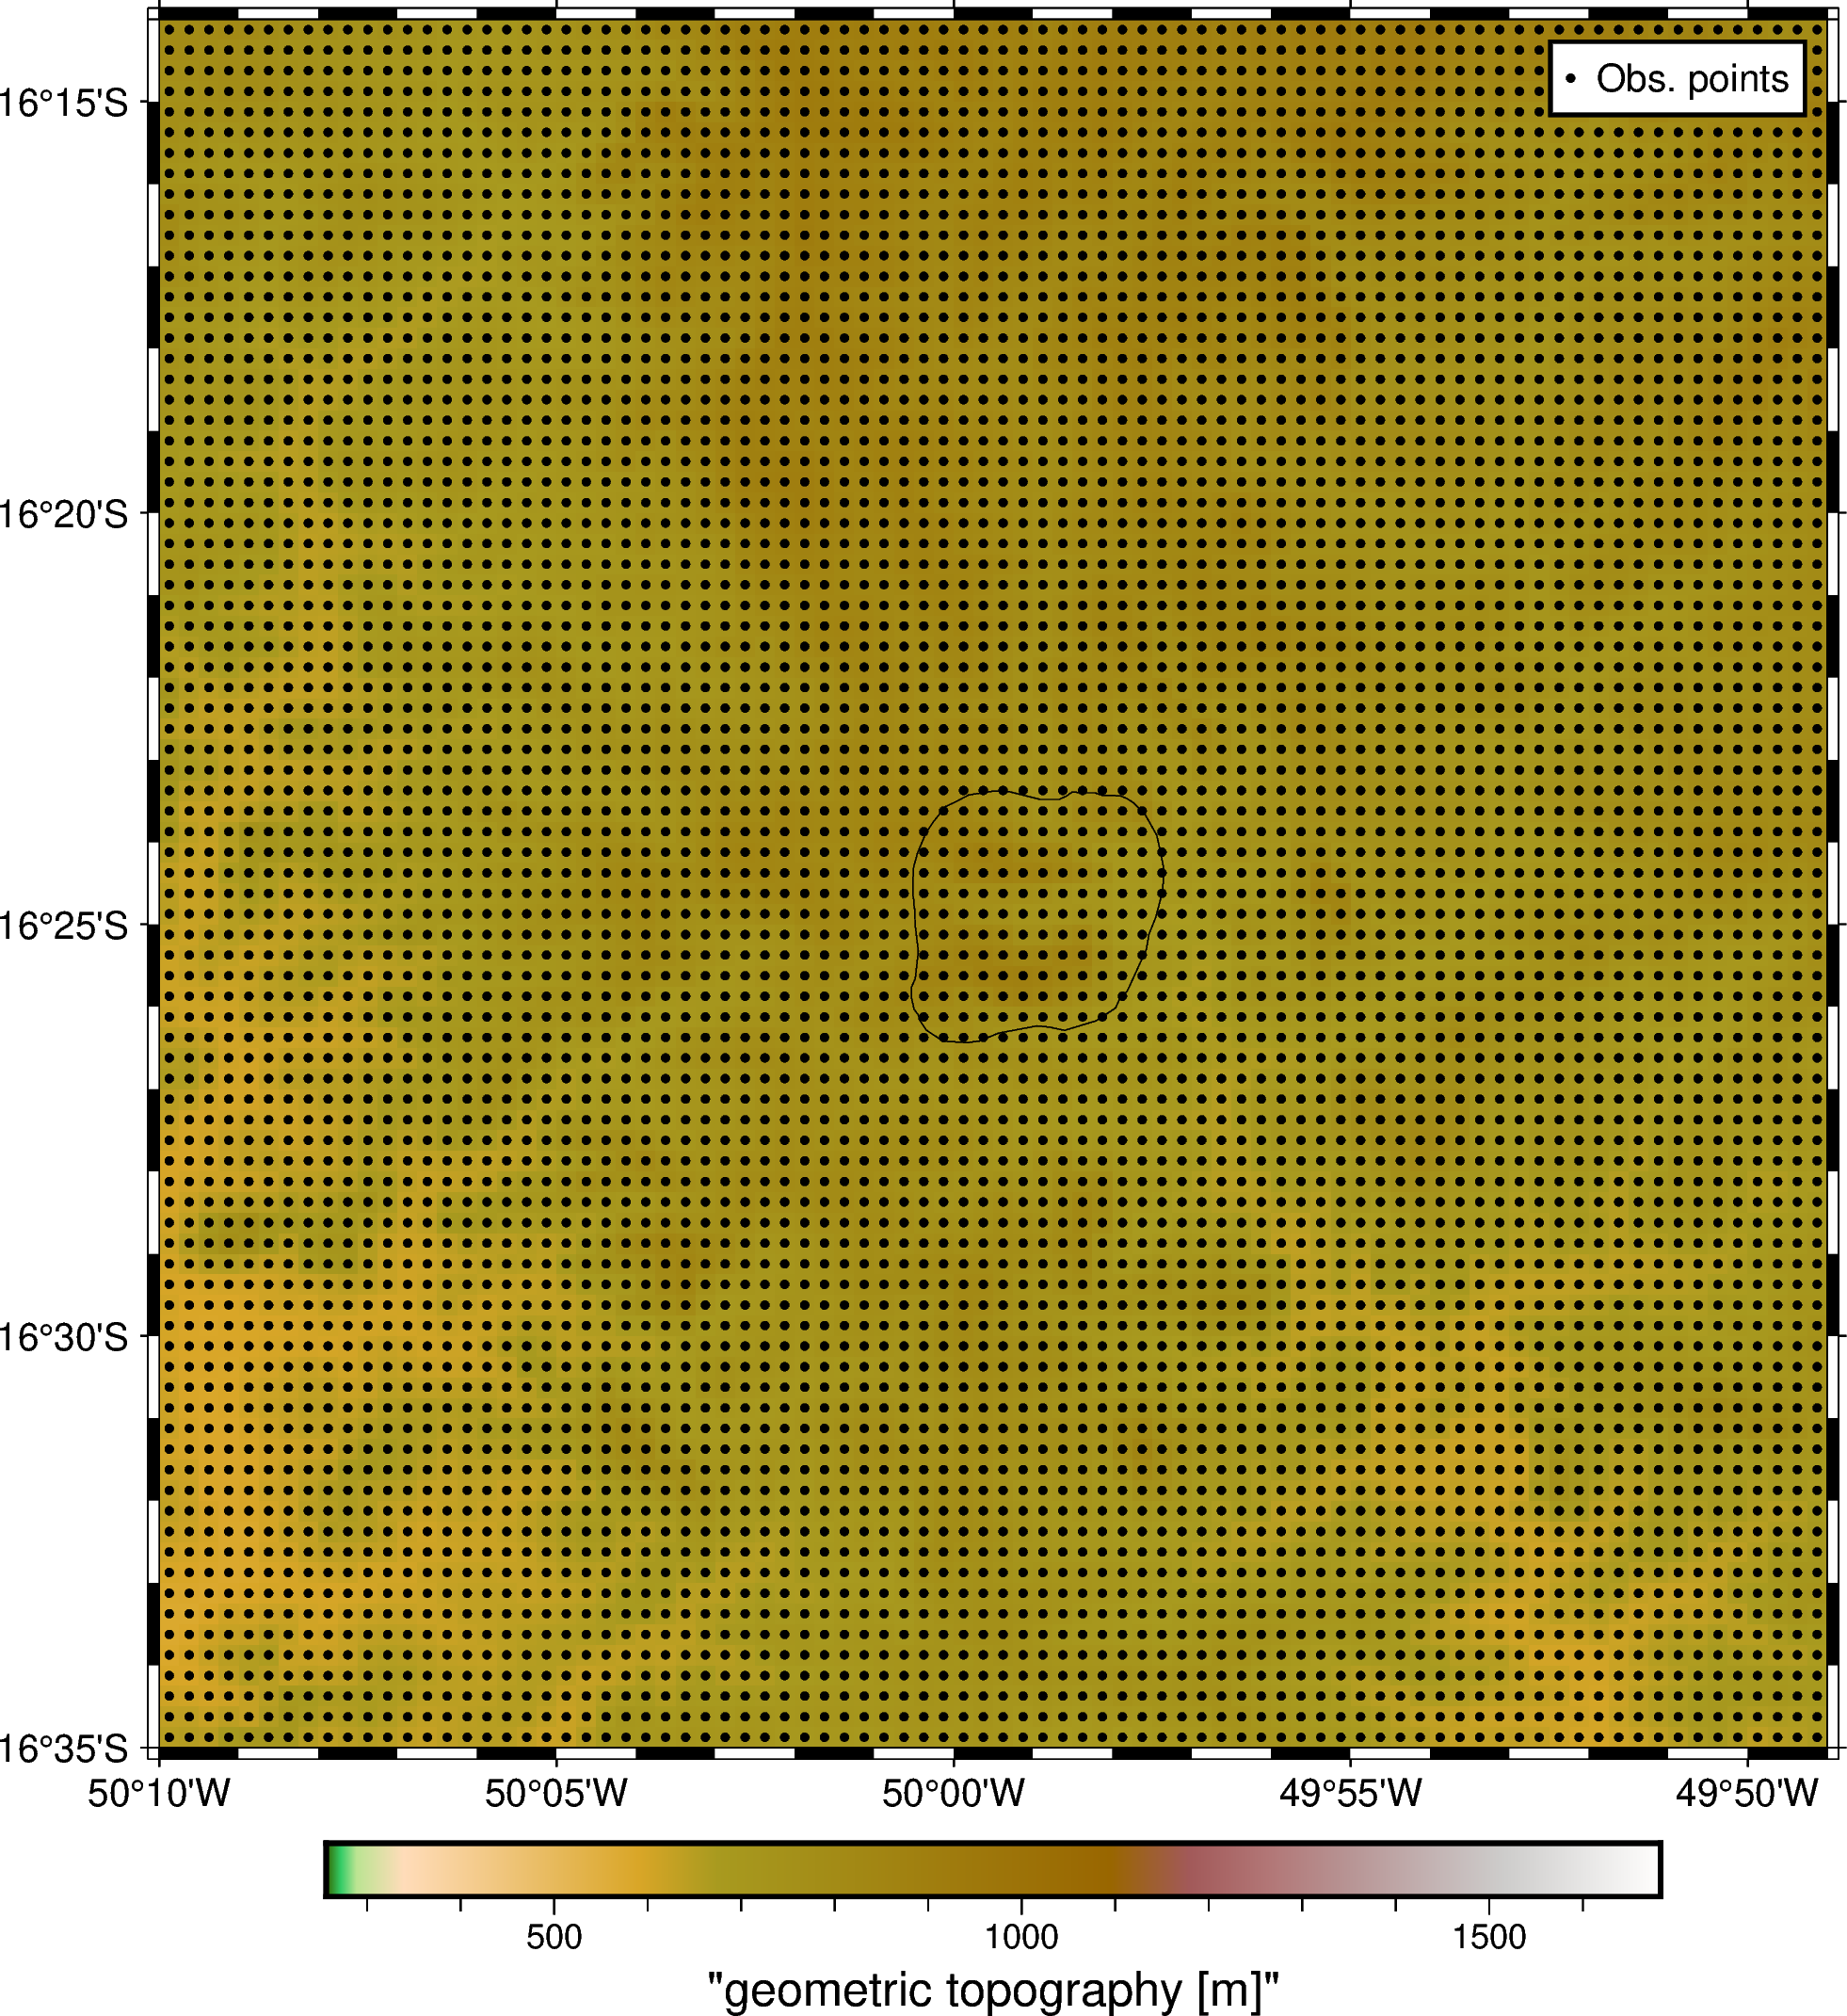

In [72]:
fig = pygmt.Figure()
fig.grdimage(topography_geometric, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geometric topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    fill="black",
    label='Obs. points'
)
fig.legend()
fig.plot(data=pluton, projection='M')
fig.show(width=600)

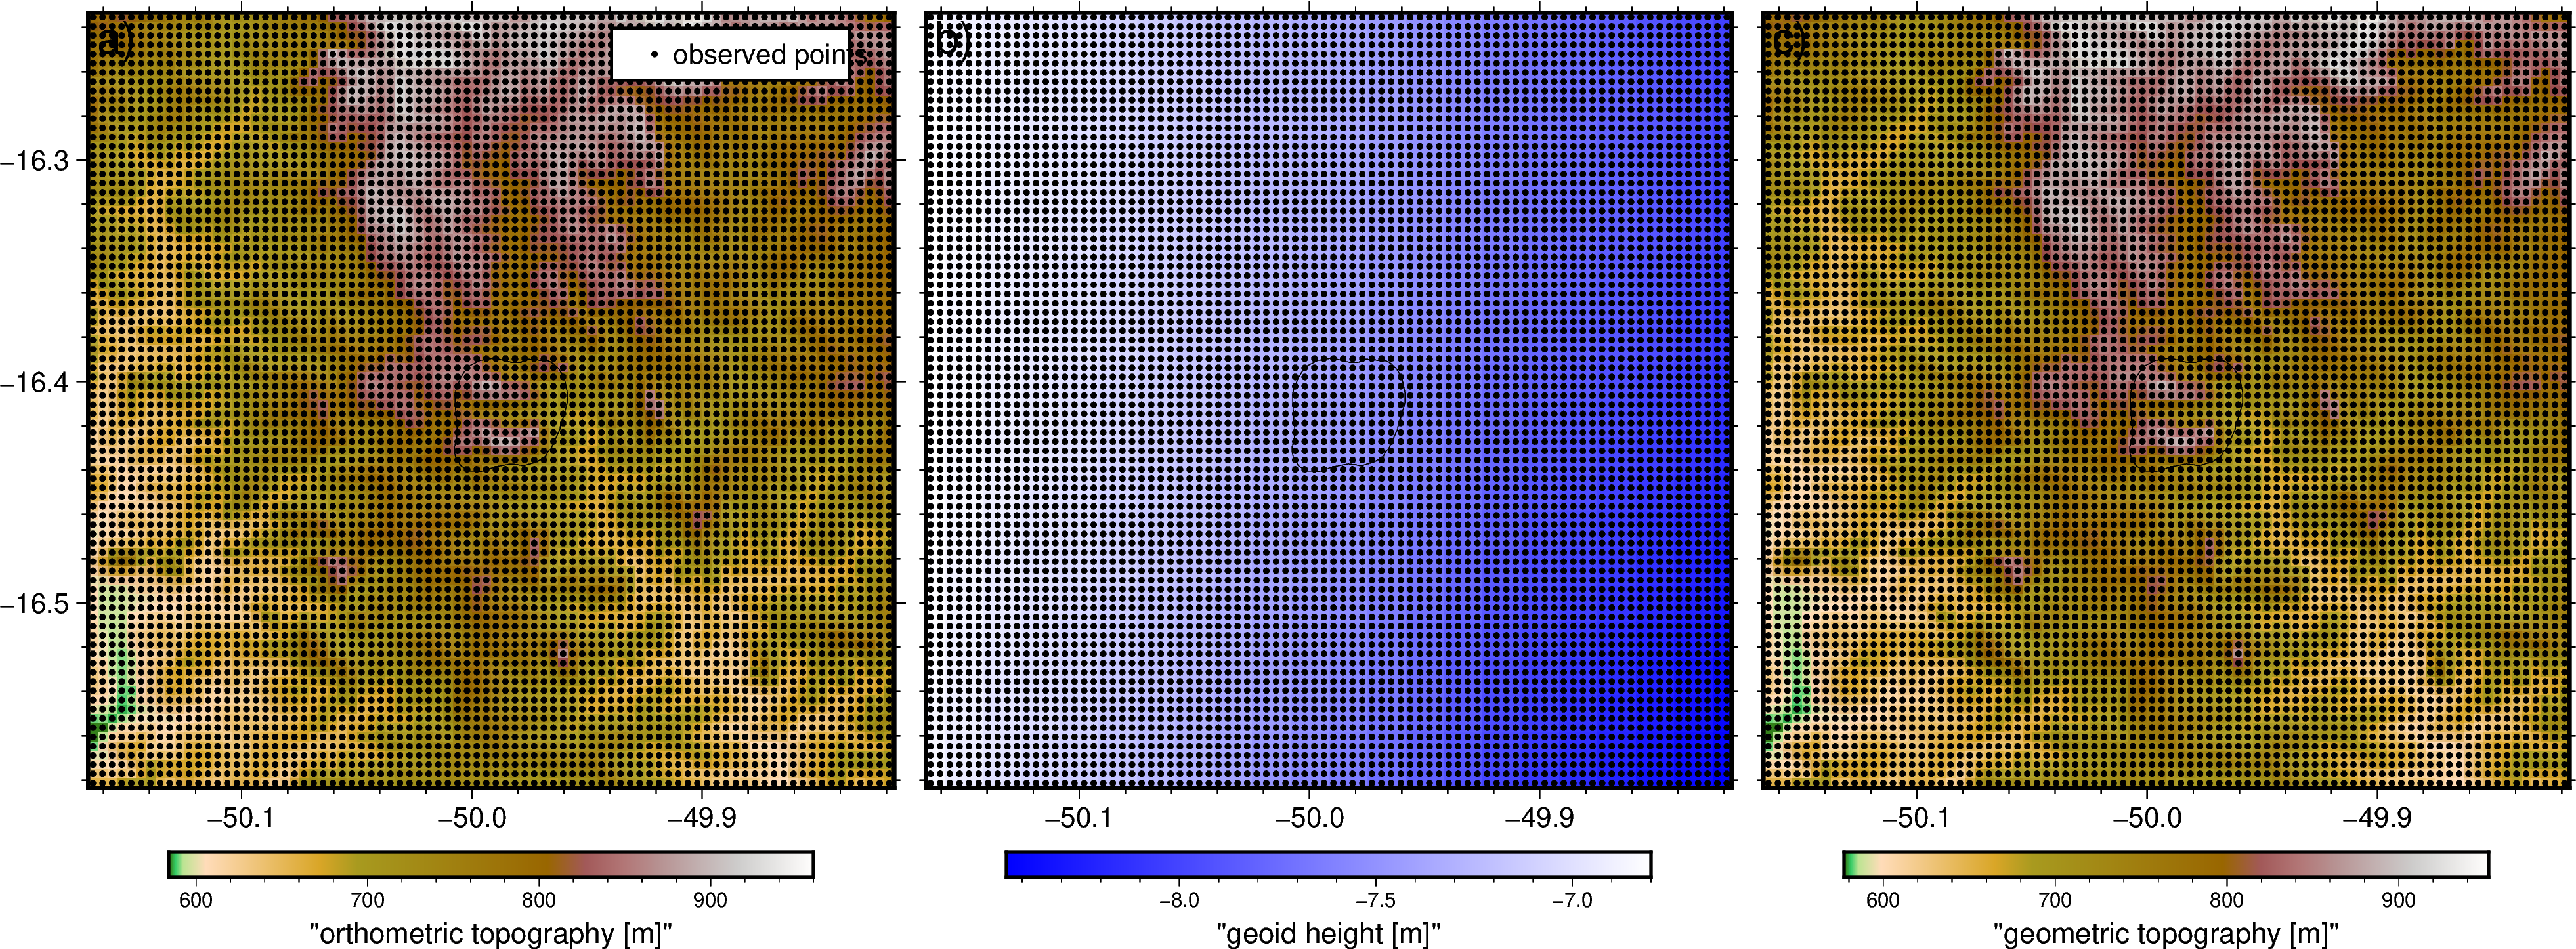

In [73]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # pygmt.config(FORMAT_GEO_MAP="ddd.xx")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            
            fig.grdimage(topography, projection="X", cmap="etopo1", frame=["WSne", "xaf", "yaf"],
                        shading="+a45+nt0.15")# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
            fig.colorbar(frame='af+l"orthometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                        label='observed points'
                    )
            fig.plot(data=pluton, projection='M')
            fig.legend()
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
    
        with fig.set_panel(panel=1):
            fig.grdimage(geoid, projection="X", cmap="polar+h", frame=["WSne", "xaf", "f"])
            fig.colorbar(frame='af+l"geoid height [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                    )
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
        with fig.set_panel(panel=2):
            fig.grdimage(topography_geometric, projection="X", cmap="etopo1", frame=["WSne", "xaf", "f"],
                        shading="+a45+nt0.15")
            fig.colorbar(frame='af+l"geometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        fill="black",
                    )
            fig.plot(data=pluton, projection='M')

fig.savefig(image_dir / 'heights.png', dpi=300)
fig.show()


In [74]:
geoid_table = vd.grid_to_table(geoid)
interpolator = vd.KNeighbors()
interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.scalars)
data = data.assign(geoid_m=interpolator.predict((data.Longitude, data.Latitude)))
data = data.assign(height_geometric_m=data.Elevation + data.geoid_m)
# data
# geoid_table

## Distúrbio da gravidade

In [75]:
data.head()

Station  Longitude   Latitude  Elevation        Gravity  geoid_m  \
0        2 -50.172917 -16.597917      594.0  978288.210050    -6.86   
1        3 -50.168750 -16.597917      595.0  978287.413200    -6.86   
2        4 -50.164583 -16.597917      603.0  978284.467233    -6.86   
3        5 -50.160417 -16.597917      616.0  978279.995975    -6.86   
4        6 -50.156250 -16.597917      626.0  978276.475002    -6.93   

   height_geometric_m  normal_gravity_mgal  gravity_disturbance_mgal  \
0              587.14        978272.730618                 15.479431   
1              588.14        978272.421960                 14.991240   
2              596.14        978269.952696                 14.514537   
3              609.14        978265.940163                 14.055812   
4              619.07        978262.875221                 13.599781   

       easting_m    northing_m  gravity_bouguer_mgal  
0  588225.577159  8.164743e+06             14.697839  
1  588670.065069  8.164741e+06             14.110907  
2  589114.553375  8.164739e+06             13.497865  
3  589559.041011  8.164737e+06             12.867773  
4  590003.530113  8.164735e+06             12.240599

In [76]:
new_data = topography_table[['latitude', 'longitude']].copy()
new_data

latitude  longitude
0    -16.597917 -50.172917
1    -16.597917 -50.168750
2    -16.597917 -50.164583
3    -16.597917 -50.160417
4    -16.597917 -50.156250
...         ...        ...
8005 -16.227083 -49.822917
8006 -16.227083 -49.818750
8007 -16.227083 -49.814583
8008 -16.227083 -49.810417
8009 -16.227083 -49.806250

[8010 rows x 2 columns]

In [77]:
interpolator = vd.KNeighbors()

# Lista das colunas a serem interpoladas
columns_to_interpolate = [
    "Station", "Gravity", 'Elevation', "geoid_m", "height_geometric_m"
]

# Iterar sobre as colunas e realizar a interpolação
for col in columns_to_interpolate:
    interpolator.fit((data.Longitude, data.Latitude), data[col])
    new_data[col] = interpolator.predict((new_data.longitude, new_data.latitude))

# Copiar as colunas que não precisam de interpolação
new_data = new_data.assign(
    Station=data.Station,
    Longitude=data.Longitude,
    Latitude=data.Latitude,
    Elevation=data.Elevation,

)

new_data

latitude  longitude  Station        Gravity  Elevation  geoid_m  \
0    -16.597917 -50.172917        2  978288.210050      594.0    -6.86   
1    -16.597917 -50.168750        3  978287.413200      595.0    -6.86   
2    -16.597917 -50.164583        4  978284.467233      603.0    -6.86   
3    -16.597917 -50.160417        5  978279.995975      616.0    -6.86   
4    -16.597917 -50.156250        6  978276.475002      626.0    -6.93   
...         ...        ...      ...            ...        ...      ...   
8005 -16.227083 -49.822917     8007  978211.084338      787.0    -8.02   
8006 -16.227083 -49.818750     8008  978201.935026      816.0    -8.02   
8007 -16.227083 -49.814583     8009  978192.159290      847.0    -8.02   
8008 -16.227083 -49.810417     8010  978185.166176      869.0    -8.02   
8009 -16.227083 -49.806250     8011  978183.125566      875.0    -8.02   

      height_geometric_m  Longitude   Latitude  
0                 587.14 -50.172917 -16.597917  
1                 588.14 -50.168750 -16.597917  
2                 596.14 -50.164583 -16.597917  
3                 609.14 -50.160417 -16.597917  
4                 619.07 -50.156250 -16.597917  
...                  ...        ...        ...  
8005              778.98 -49.822917 -16.227083  
8006              807.98 -49.818750 -16.227083  
8007              838.98 -49.814583 -16.227083  
8008              860.98 -49.810417 -16.227083  
8009              866.98 -49.806250 -16.227083  

[8010 rows x 9 columns]

In [80]:
data = new_data

In [81]:
data = data.assign(
    normal_gravity_mgal=bl.WGS84.normal_gravity(data.Latitude, data.height_geometric_m)
)
data = data.assign(gravity_disturbance_mgal=data.Gravity - data.normal_gravity_mgal)
data.head()

latitude  longitude  Station        Gravity  Elevation  geoid_m  \
0 -16.597917 -50.172917        2  978288.210050      594.0    -6.86   
1 -16.597917 -50.168750        3  978287.413200      595.0    -6.86   
2 -16.597917 -50.164583        4  978284.467233      603.0    -6.86   
3 -16.597917 -50.160417        5  978279.995975      616.0    -6.86   
4 -16.597917 -50.156250        6  978276.475002      626.0    -6.93   

   height_geometric_m  Longitude   Latitude  normal_gravity_mgal  \
0              587.14 -50.172917 -16.597917        978272.730618   
1              588.14 -50.168750 -16.597917        978272.421960   
2              596.14 -50.164583 -16.597917        978269.952696   
3              609.14 -50.160417 -16.597917        978265.940163   
4              619.07 -50.156250 -16.597917        978262.875221   

   gravity_disturbance_mgal  
0                 15.479431  
1                 14.991240  
2                 14.514537  
3                 14.055812  
4                 13.599781

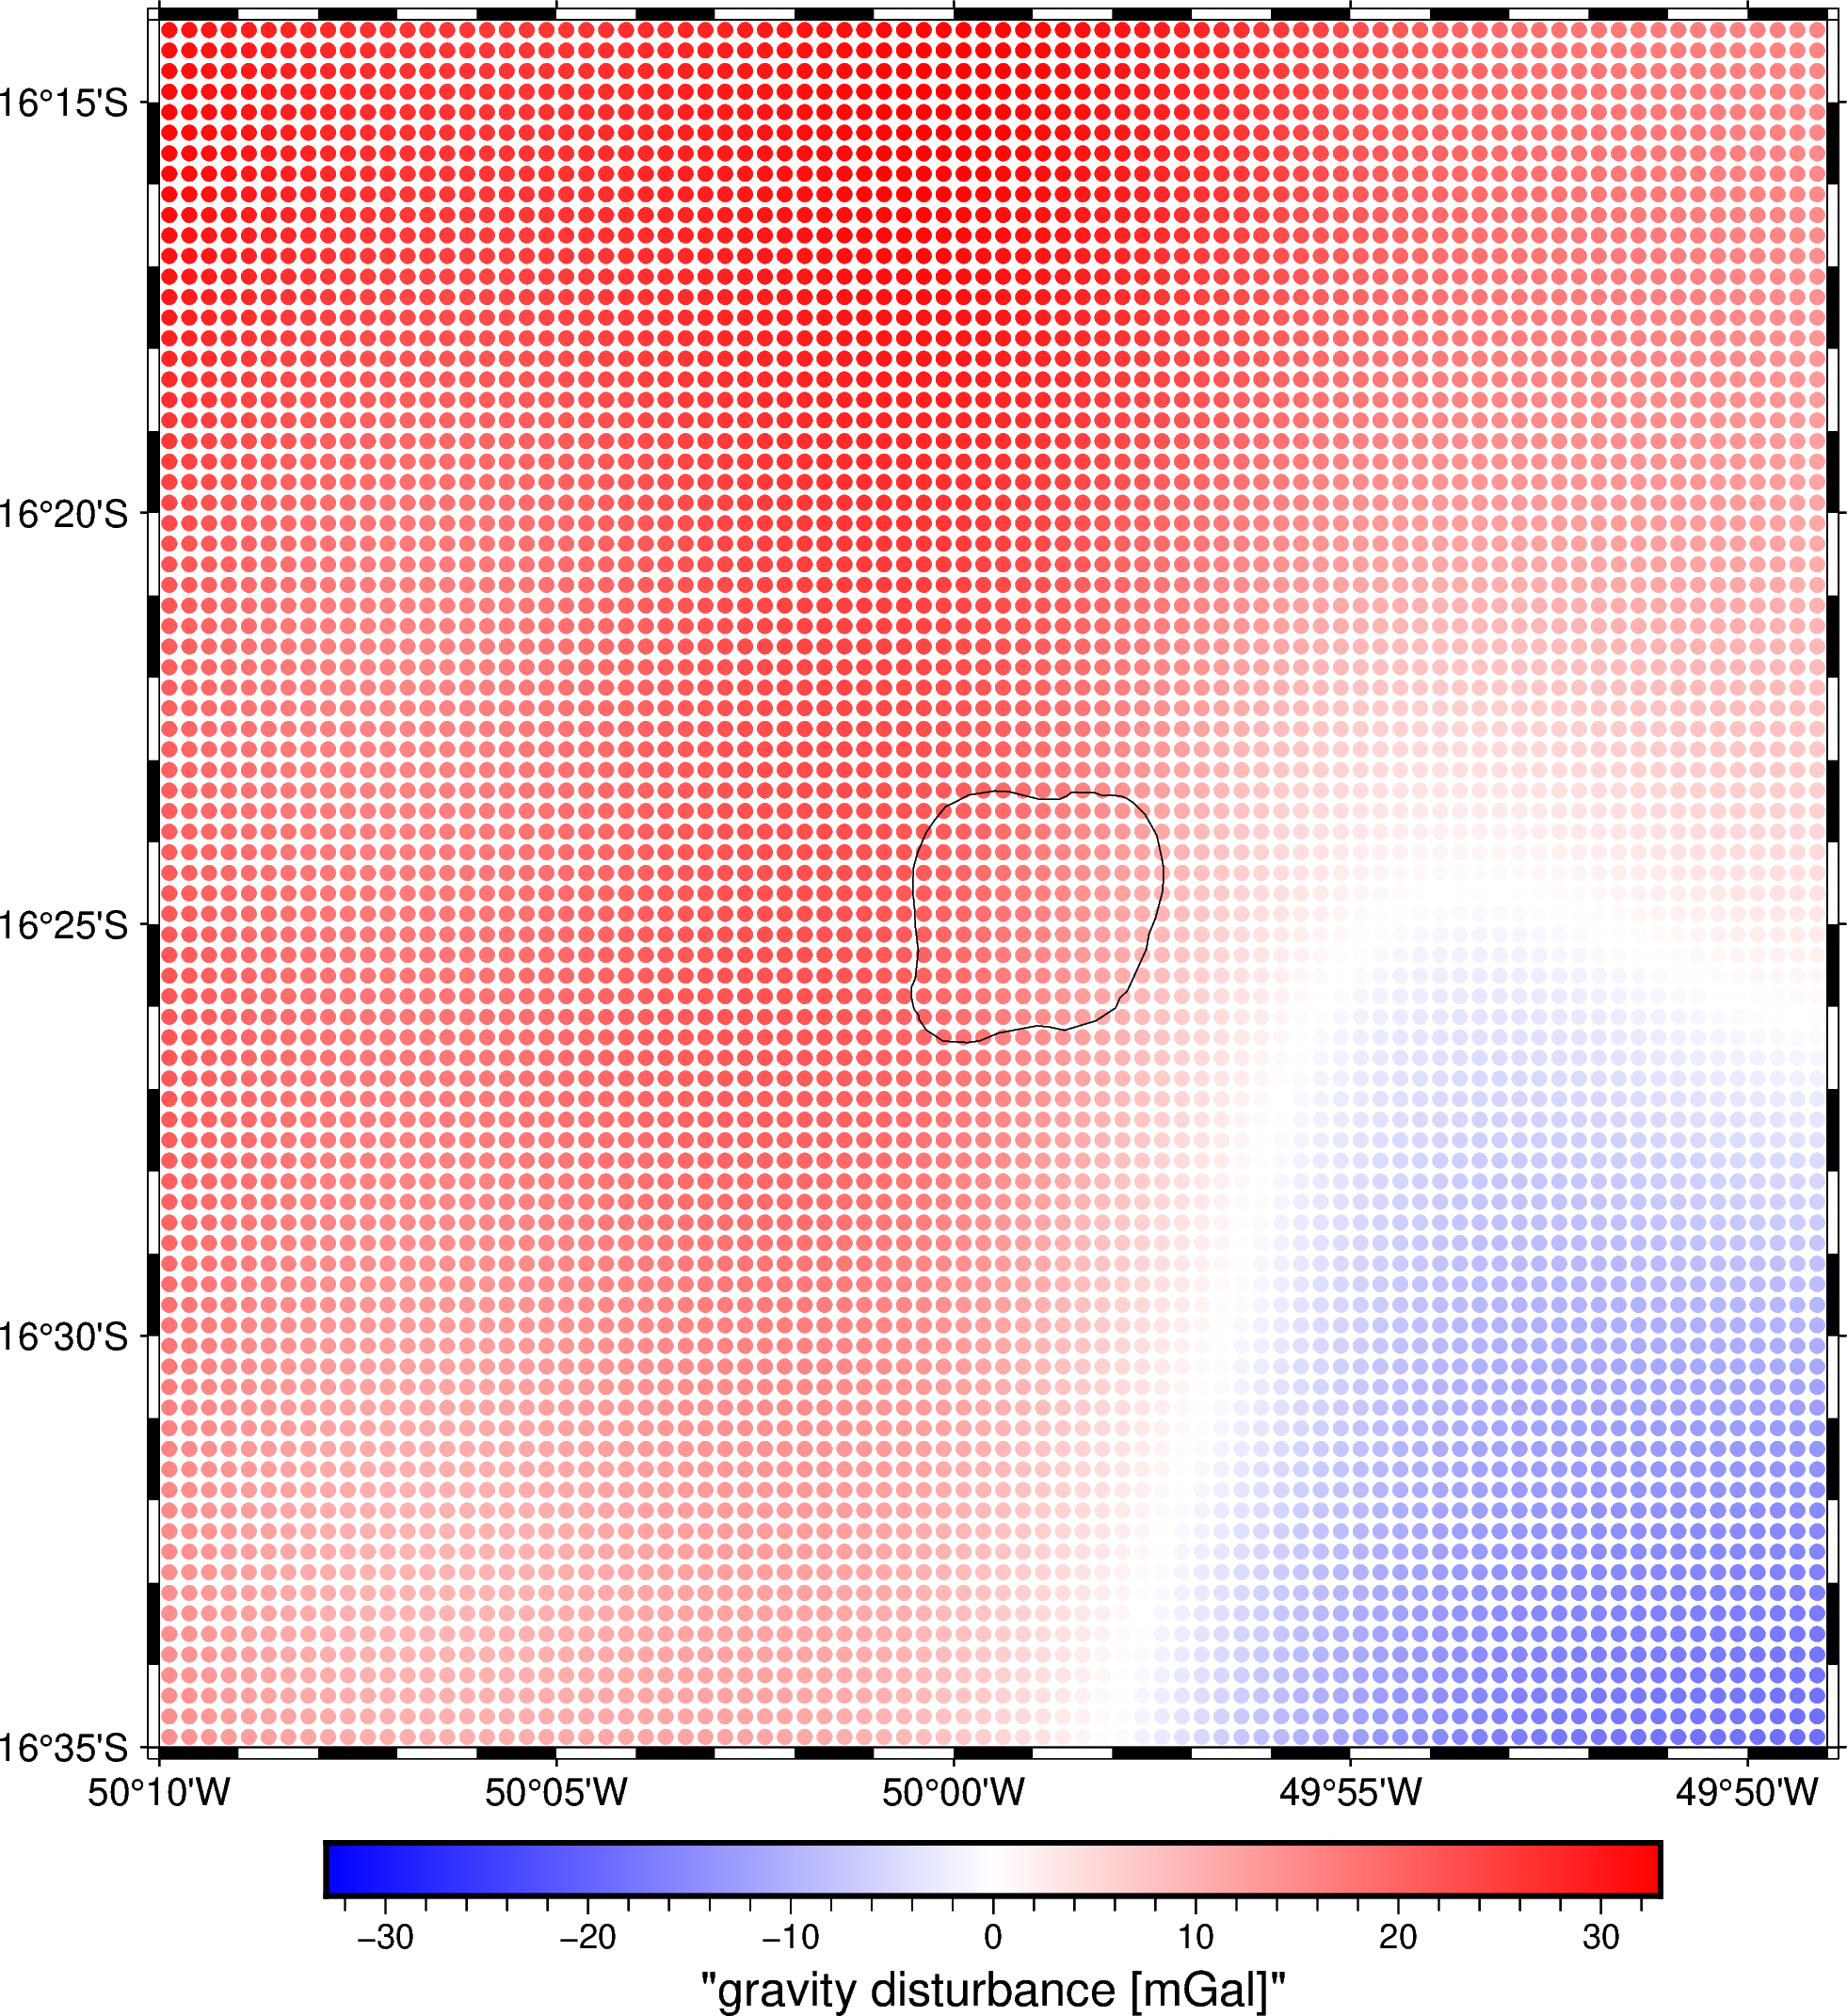

In [82]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="af",
)
fig.plot(data=pluton, projection='M')
fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show(width=600)

image

<!-- ## Correção topográfica -->

<!-- ![](https://www.fatiando.org/tutorials/_images/topographic-correction.svg) -->

In [83]:
# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
projection = pyproj.Proj(proj='utm', ellps='WGS84', zone=22, south=True)

In [84]:
easting, northing = projection(data.Longitude.values, data.Latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data.head(5)

latitude  longitude  Station        Gravity  Elevation  geoid_m  \
0 -16.597917 -50.172917        2  978288.210050      594.0    -6.86   
1 -16.597917 -50.168750        3  978287.413200      595.0    -6.86   
2 -16.597917 -50.164583        4  978284.467233      603.0    -6.86   
3 -16.597917 -50.160417        5  978279.995975      616.0    -6.86   
4 -16.597917 -50.156250        6  978276.475002      626.0    -6.93   

   height_geometric_m  Longitude   Latitude  normal_gravity_mgal  \
0              587.14 -50.172917 -16.597917        978272.730618   
1              588.14 -50.168750 -16.597917        978272.421960   
2              596.14 -50.164583 -16.597917        978269.952696   
3              609.14 -50.160417 -16.597917        978265.940163   
4              619.07 -50.156250 -16.597917        978262.875221   

   gravity_disturbance_mgal      easting_m    northing_m  
0                 15.479431  588225.577159  8.164743e+06  
1                 14.991240  588670.065069  8.164741e+06  
2                 14.514537  589114.553375  8.164739e+06  
3                 14.055812  589559.041011  8.164737e+06  
4                 13.599781  590003.530113  8.164735e+06

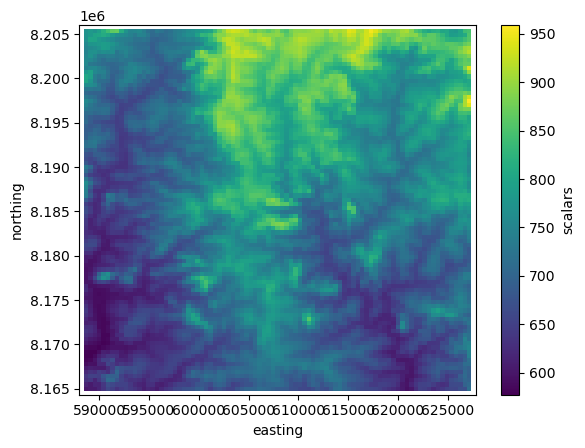

In [85]:
topography_proj = vd.project_grid(topography_geometric, projection, method="nearest")
topography_proj.plot()

In [86]:
topography_density = np.where(topography_proj > 0, 2670, 1040 - 2670)
topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": topography_density}
)
# topography_model.density.plot()

In [87]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)
terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")

In [88]:
data = data.assign(
    gravity_bouguer_mgal=data.gravity_disturbance_mgal - terrain_effect
)
data.head()

latitude  longitude  Station        Gravity  Elevation  geoid_m  \
0 -16.597917 -50.172917        2  978288.210050      594.0    -6.86   
1 -16.597917 -50.168750        3  978287.413200      595.0    -6.86   
2 -16.597917 -50.164583        4  978284.467233      603.0    -6.86   
3 -16.597917 -50.160417        5  978279.995975      616.0    -6.86   
4 -16.597917 -50.156250        6  978276.475002      626.0    -6.93   

   height_geometric_m  Longitude   Latitude  normal_gravity_mgal  \
0              587.14 -50.172917 -16.597917        978272.730618   
1              588.14 -50.168750 -16.597917        978272.421960   
2              596.14 -50.164583 -16.597917        978269.952696   
3              609.14 -50.160417 -16.597917        978265.940163   
4              619.07 -50.156250 -16.597917        978262.875221   

   gravity_disturbance_mgal      easting_m    northing_m  gravity_bouguer_mgal  
0                 15.479431  588225.577159  8.164743e+06              7.516939  
1                 14.991240  588670.065069  8.164741e+06             -4.641283  
2                 14.514537  589114.553375  8.164739e+06             -9.400984  
3                 14.055812  589559.041011  8.164737e+06            -11.764325  
4                 13.599781  590003.530113  8.164735e+06            -13.250002

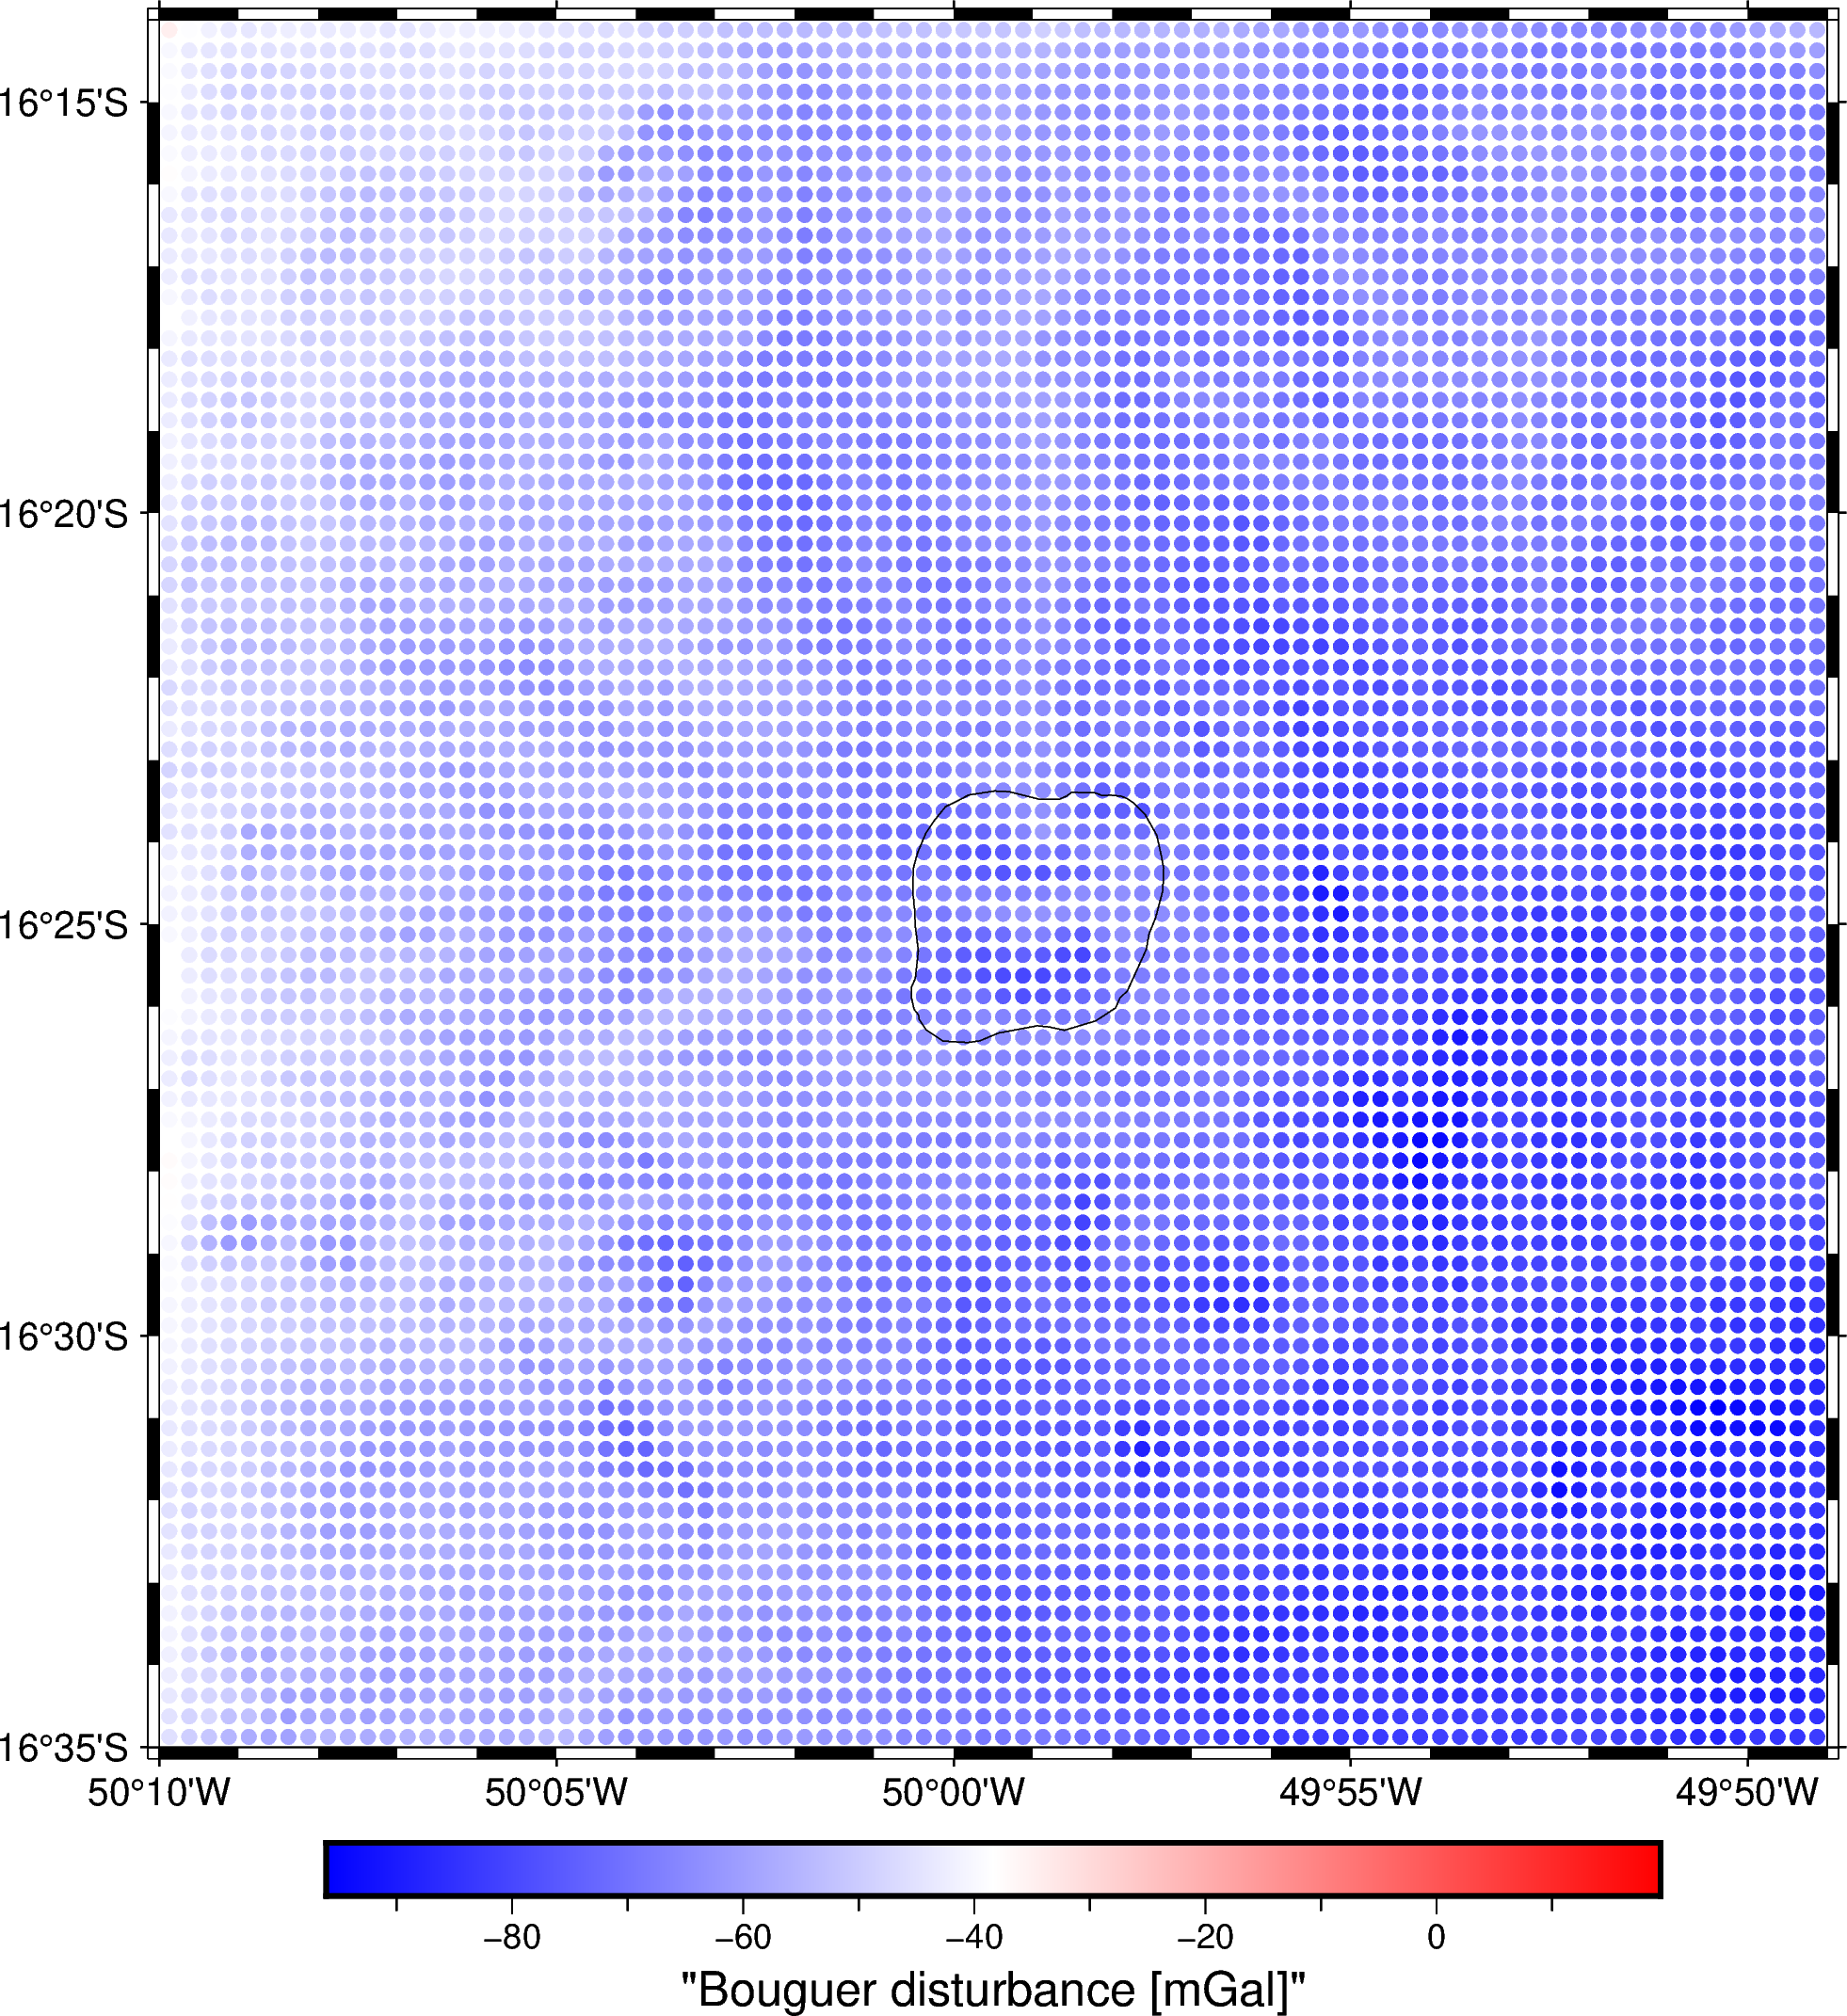

In [91]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar", series=[np.min(data.gravity_bouguer_mgal), np.max(data.gravity_bouguer_mgal)])
# pygmt.makecpt(cmap="polar", series=[-90, -10])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    fill=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

In [102]:
eqs = hm.EquivalentSources(damping=1.0, depth=30e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m),  data.gravity_bouguer_mgal) # data.gravity_bouguer_mgal)

EquivalentSources(damping=1.0, depth=30000.0)

In [103]:
# Interpolar extra coord a partir da topografia
region_pad_2 = vd.pad_region(region, pad=-0.05)
grid_extra_coord = vd.grid_coordinates(region_pad_2, spacing= 2 / 3600)

interpolator = vd.KNeighbors()
topography_table = vd.grid_to_table(topography)
interpolator.fit((topography_table.longitude, topography_table.latitude), topography_table.z)
extra_coord=interpolator.predict((grid_extra_coord[0], grid_extra_coord[1]))

# geoid_values = np.reshape(geoid_1.elevation, topography.shape)
coordinates_grid = ([grid_extra_coord[0], grid_extra_coord[1], extra_coord])

In [104]:
regional_grid = eqs.grid(
    # coordinates=vd.grid_coordinates(region_pad_2, spacing=2 / 3600, extra_coords=1.0e3),
    coordinates=coordinates_grid,
    data_names="gravity_regional",
    dims=("latitude", "longitude"),
    projection=projection,
)
regional_grid

<xarray.Dataset> Size: 4MB
Dimensions:           (latitude: 496, longitude: 481)
Coordinates:
  * longitude         (longitude) float64 4kB -50.12 -50.12 ... -49.86 -49.86
  * latitude          (latitude) float64 4kB -16.55 -16.55 ... -16.27 -16.27
    upward            (latitude, longitude) float64 2MB 614.0 614.0 ... 833.0
Data variables:
    gravity_regional  (latitude, longitude) float64 2MB -55.03 -55.19 ... -65.45
Attributes:
    metadata:  Generated by EquivalentSources(damping=1.0, depth=30000.0)

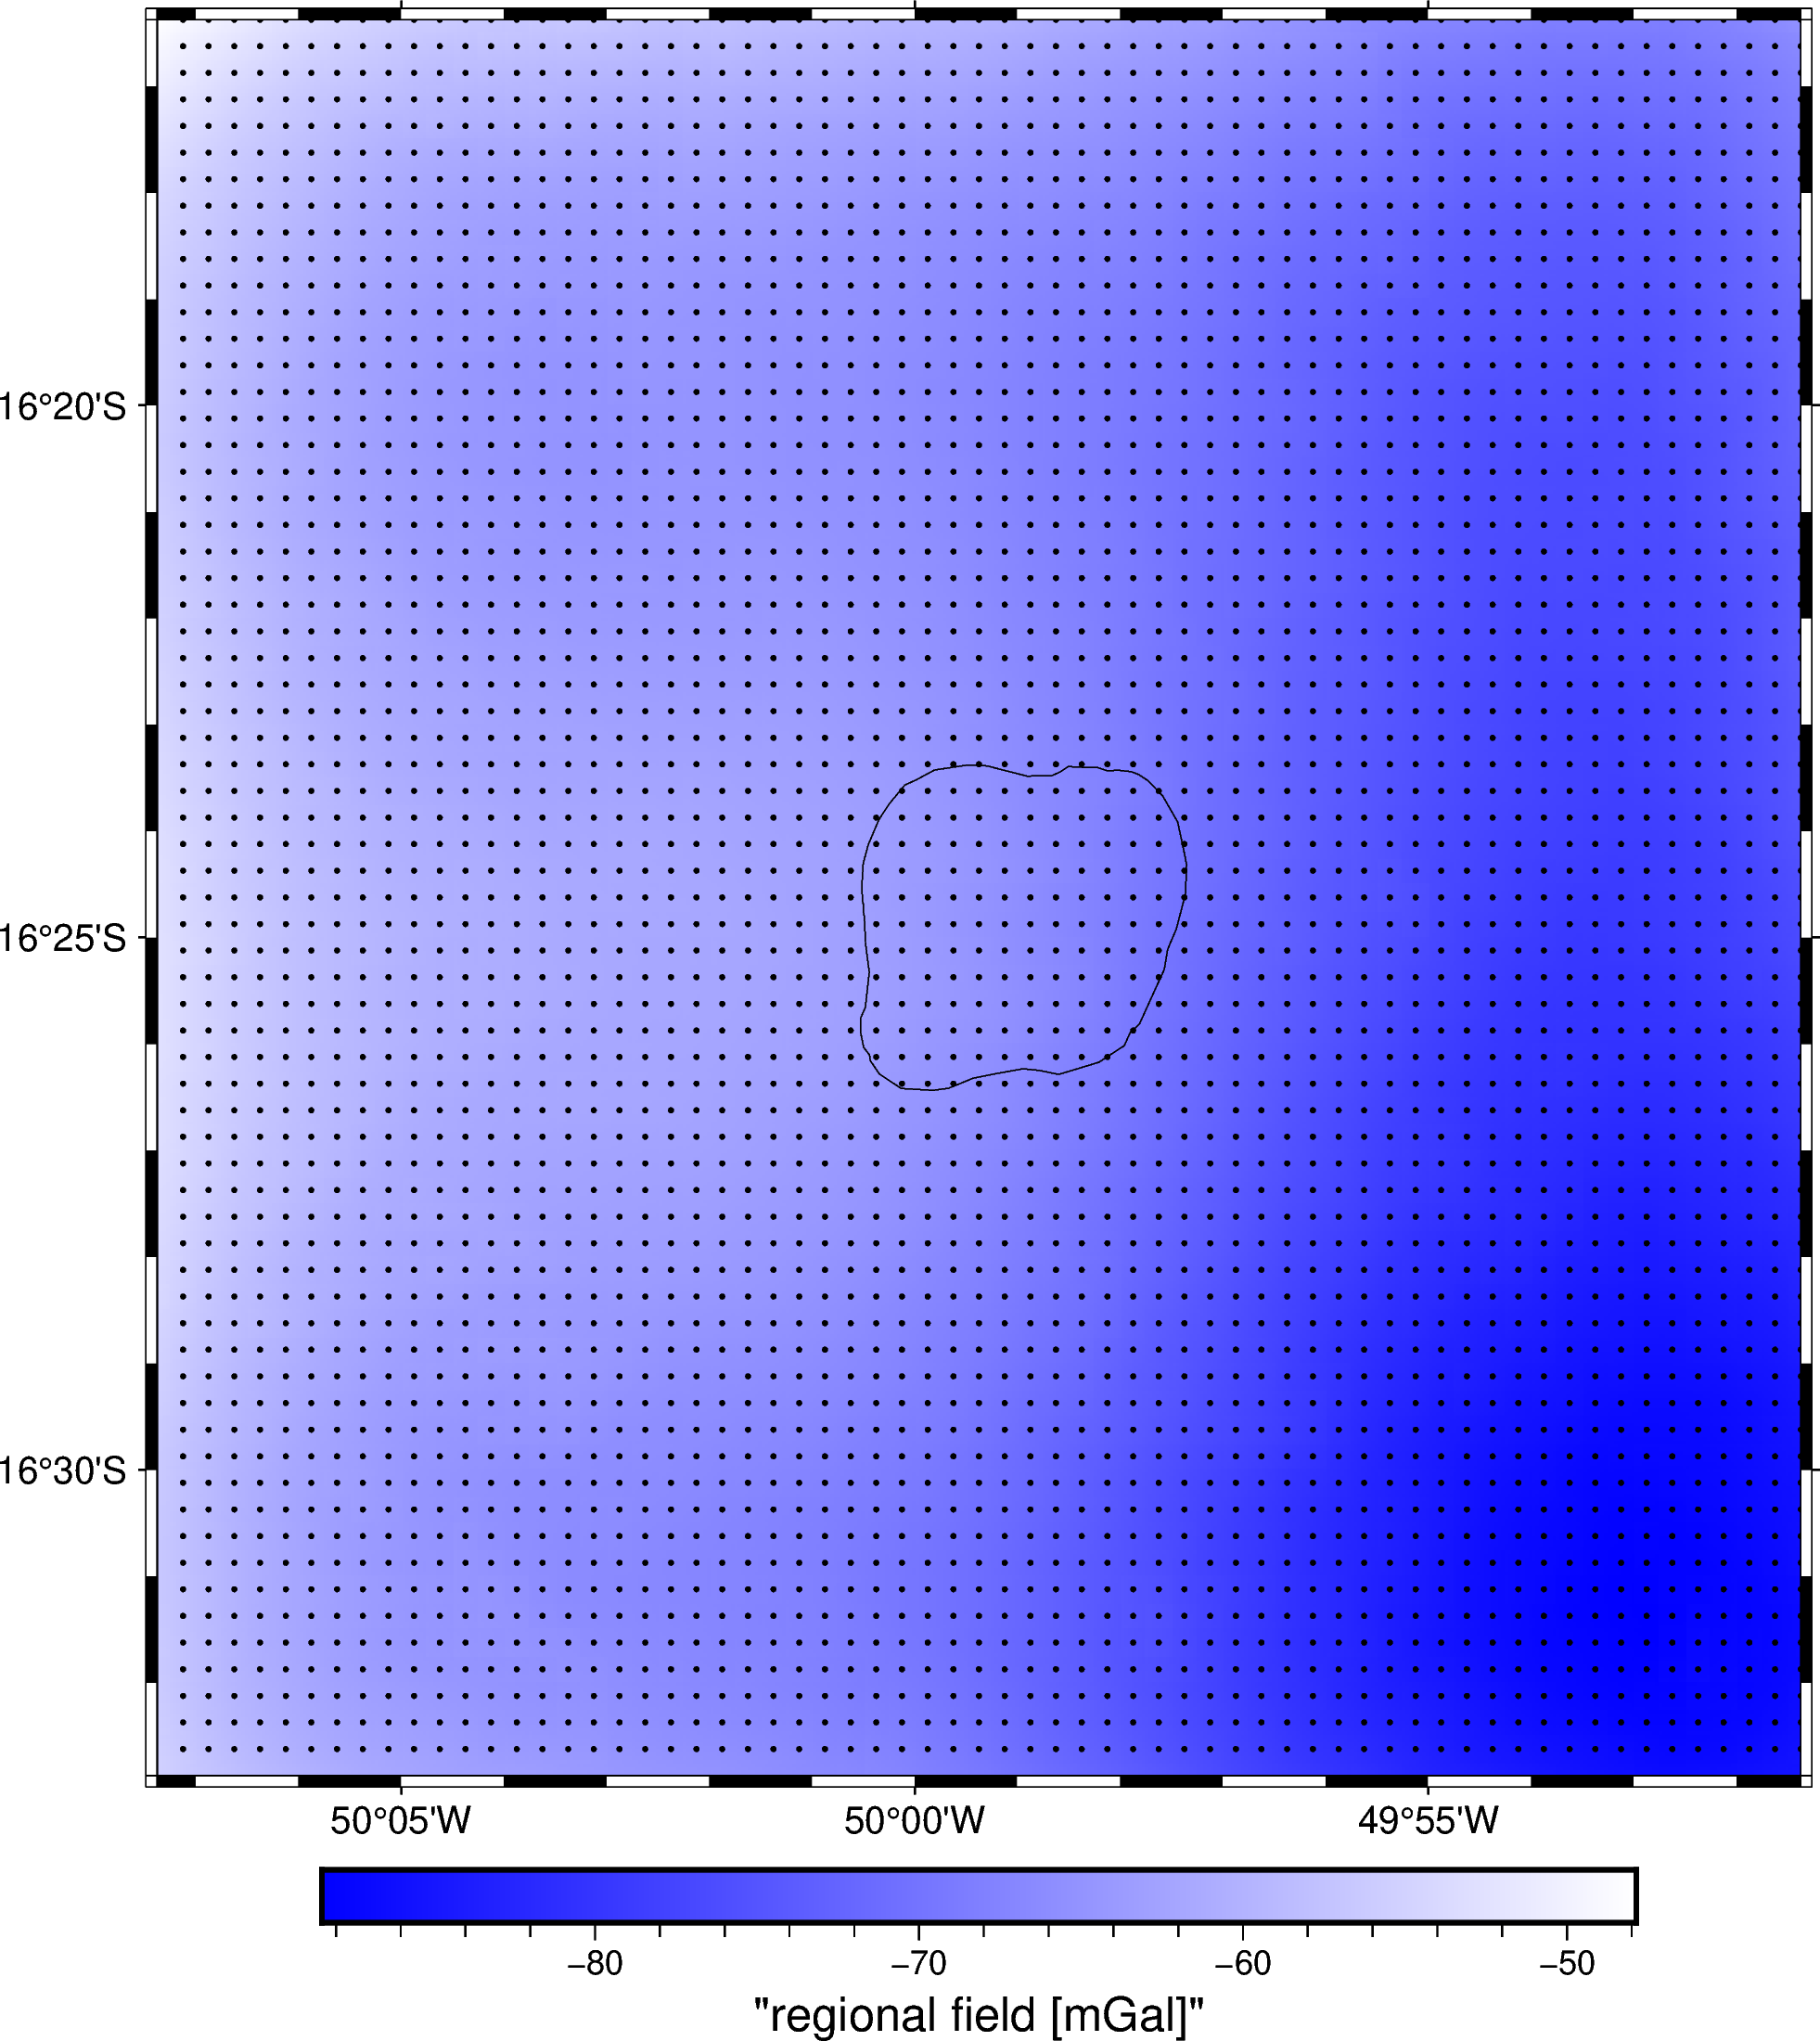

In [105]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[np.min(regional_grid.gravity_regional.values), 
                                      np.max(regional_grid.gravity_regional.values)], no_bg=True)
# pygmt.makecpt(cmap="polar+h", series=[-85, -40], no_bg=True)
fig.grdimage(
    regional_grid.gravity_regional,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=vd.pad_region(region, pad=-0.05)
)
fig.colorbar(frame='af+l"regional field [mGal]"')
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.05c",
    fill="black",
)
fig.plot(data=pluton, projection='M')
 
fig.show()

In [106]:
# Validação cruzada entre dados de grav residual e camada equivalente
r2_score = np.mean(
    vd.cross_val_score(
        eqs,
        coordinates,
        data.gravity_bouguer_mgal,
    )
)
print(f'O R² do modelo de camada equivalente para os dados é de: {r2_score:.3f}')

O R² do modelo de camada equivalente para os dados é de: 0.702


In [107]:
# Dados Locais
valores_a_remover = ['csg5_001', 'csg5_003', 'csg2_005', 'csg9_001']
df_local = pd.read_csv(data_dir/'CSG.csv', delimiter=',')
colunas_especificas = ['Latitude', 'Longitude', 'Gravity', 'Elevation', 'Station']
df_local = df_local[colunas_especificas]
df_local = df_local[~df_local['Station'].isin(valores_a_remover)]
df_local.head(10)

Latitude  Longitude        Gravity  Elevation    Station
0 -16.386936 -49.962121  978224.514612    749.009  csg10_001
1 -16.386212 -49.967838  978217.706954    796.077  csg10_002
2 -16.382504 -49.963106  978220.923469    764.537  csg10_003
3 -16.431268 -49.966788  978230.218997    734.446  csg10_005
4 -16.430324 -49.964049  978236.632548    694.596  csg10_006
5 -16.432018 -49.959065  978239.055513    672.365  csg10_007
6 -16.439817 -49.956038  978230.584075    703.841  csg10_008
7 -16.446370 -49.965245  978228.828473    721.347  csg10_009
8 -16.424009 -49.996369  978219.024025    882.687   csg2_001
9 -16.425004 -49.994198  978215.202400    892.382   csg2_002

## Interpolate the Bouguer disturbance into the local data file

In [108]:
regional_grid_table = vd.grid_to_table(regional_grid)
regional_grid_table.head(10)

latitude  longitude  upward  gravity_regional
0 -16.547917 -50.122917   614.0        -55.034418
1 -16.547917 -50.122361   614.0        -55.190641
2 -16.547917 -50.121806   614.0        -55.345117
3 -16.547917 -50.121250   614.0        -55.497853
4 -16.547917 -50.120694   613.0        -55.655802
5 -16.547917 -50.120139   613.0        -55.805074
6 -16.547917 -50.119583   613.0        -55.952621
7 -16.547917 -50.119028   613.0        -56.098448
8 -16.547917 -50.118472   613.0        -56.242560
9 -16.547917 -50.117917   613.0        -56.384963

In [109]:
interpolator = vd.KNeighbors()
interpolator.fit((regional_grid_table.longitude, regional_grid_table.latitude), regional_grid_table.gravity_regional)
df_local = df_local.assign(regional_bouguer=interpolator.predict((df_local.Longitude, df_local.Latitude)))
df_local.head(10)

Latitude  Longitude        Gravity  Elevation    Station  regional_bouguer
0 -16.386936 -49.962121  978224.514612    749.009  csg10_001        -69.029778
1 -16.386212 -49.967838  978217.706954    796.077  csg10_002        -68.062177
2 -16.382504 -49.963106  978220.923469    764.537  csg10_003        -68.968925
3 -16.431268 -49.966788  978230.218997    734.446  csg10_005        -68.764783
4 -16.430324 -49.964049  978236.632548    694.596  csg10_006        -69.324786
5 -16.432018 -49.959065  978239.055513    672.365  csg10_007        -70.402072
6 -16.439817 -49.956038  978230.584075    703.841  csg10_008        -71.269366
7 -16.446370 -49.965245  978228.828473    721.347  csg10_009        -69.963276
8 -16.424009 -49.996369  978219.024025    882.687   csg2_001        -64.087910
9 -16.425004 -49.994198  978215.202400    892.382   csg2_002        -64.308627

## Save it into a new csv file

In [110]:
df_local.to_csv(data_dir/'CSG_with_regional_from_satellite.csv', sep=',', index=False)

In [111]:
df_local.shape

(56, 6)